In [ ]:
from scipy.io import loadmat
!pip install feature_engine
!pip install catboost
!pip install scikit-learn==1.0.2
!pip install imbalanced-learn==0.8.0
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, gc, joblib, re
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, chi2, RFE, SequentialFeatureSelector
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from yellowbrick.classifier import ClassPredictionError
filename = '../data/data.csv'

In [ ]:
data = pd.read_csv(filename)
df=data.copy()
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [ ]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    #print("##################### Head #####################")
    #print(dataframe.head(3))
    #print("##################### Tail #####################")
    #print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
check_df(df)

##################### Shape #####################
(6819, 96)
##################### Types #####################
Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object
##################### NA #####################
Bankrupt?                                                   0
 ROA(C

In [ ]:
df.drop(df.columns[df.nunique() == 1][0],axis=1,inplace=True)
df.columns = df.columns.str.replace(' ','')

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    为给定的数据框获取列名

    :param dataframe: 数据框
    :param cat_th: 分类列的阈值
    :param car_th: 高基数分类列的阈值
    :return: 分类列，高基数分类列，数值列
    """

    # 获取所有数据类型为对象（字符串）的列
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    # 获取唯一值小于 cat_th 且数据类型不为对象的列
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    # 获取唯一值大于 car_th 且数据类型为对象的列
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    # 合并分类列和数值但被当作分类的列，并去除高基数分类列
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # 获取所有数据类型不为对象的列，并去除数值但被当作分类的列
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # 打印数据框的观察数和变量数，以及各类列的数量
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # 返回分类列，高基数分类列和数值列
    return cat_cols, cat_but_car, num_cols

# 调用函数获取列名
cat_cols, cat_but_car, num_cols = grab_col_names(df)


Observations: 6819
Variables: 95
cat_cols: 2
num_cols: 93
cat_but_car: 0
num_but_cat: 2


In [ ]:
# 计算异常值阈值
def outlier_thresholds(dataframe, variable, low_quantile=0.15, up_quantile=0.85):
    # 计算第一个分位数
    quantile_one = dataframe[variable].quantile(low_quantile)
    # 计算第三个分位数
    quantile_three = dataframe[variable].quantile(up_quantile)
    # 计算四分位距
    interquantile_range = quantile_three - quantile_one
    # 计算上限
    up_limit = quantile_three + 1.5 * interquantile_range
    # 计算下限
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# 异常值检查
def check_outlier(dataframe, col_name):
    # 获取列的异常值上下限
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    # 检查是否存在异常值
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# 对数值列进行异常值检查
for col in num_cols:
    print(col, check_outlier(df, col))


ROA(C)beforeinterestanddepreciationbeforeinterest True
ROA(A)beforeinterestand%aftertax True
ROA(B)beforeinterestanddepreciationaftertax True
OperatingGrossMargin True
RealizedSalesGrossMargin True
OperatingProfitRate True
Pre-taxnetInterestRate True
After-taxnetInterestRate True
Non-industryincomeandexpenditure/revenue True
Continuousinterestrate(aftertax) True
OperatingExpenseRate False
Researchanddevelopmentexpenserate False
Cashflowrate True
Interest-bearingdebtinterestrate True
Taxrate(A) True
NetValuePerShare(B) True
NetValuePerShare(A) True
NetValuePerShare(C) True
PersistentEPSintheLastFourSeasons True
CashFlowPerShare True
RevenuePerShare(Yuan¥) True
OperatingProfitPerShare(Yuan¥) True
PerShareNetprofitbeforetax(Yuan¥) True
RealizedSalesGrossProfitGrowthRate True
OperatingProfitGrowthRate True
After-taxNetProfitGrowthRate True
RegularNetProfitGrowthRate True
ContinuousNetProfitGrowthRate True
TotalAssetGrowthRate False
NetValueGrowthRate True
TotalAssetReturnGrowthRateRatio Tr

In [ ]:
# 异常值的替换
def replace_with_thresholds(dataframe, variable):
    # 获取列的异常值上下限
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # 将低于下限的值替换为下限
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    # 将高于上限的值替换为上限
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# 对数值列进行异常值替换，排除"SalePrice"列
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df, col)

In [ ]:
X = df.drop('Bankrupt?',axis=1)
y = df['Bankrupt?']

In [ ]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])
deleted_features = {}

# 运行流水线的每一步，并记录被删除的特征
for name, step in pipeline.steps:
    X_transformed = step.fit_transform(X)
    # 获取被保留的特征索引
    retained_indices = step.get_support(indices=True)
    # 记录被删除的特征
    deleted_features[name] = [col for i, col in enumerate(X.columns) if i not in retained_indices]
    # 更新 X 为转换后的结果
    X = X_transformed

# 打印每一步被删除的特征
for step_name, features in deleted_features.items():
    print(f"Features deleted in step {step_name}: {features}")

X = pipeline.fit_transform(X)
X.shape

Features deleted in step constant: []
Features deleted in step correlated: ['ROA(C)beforeinterestanddepreciationbeforeinterest', 'ROA(A)beforeinterestand%aftertax', 'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin', 'RealizedSalesGrossMargin', 'OperatingProfitRate', 'Pre-taxnetInterestRate', 'Continuousinterestrate(aftertax)', 'Cashflowrate', 'NetValuePerShare(B)', 'NetValuePerShare(C)', 'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare', 'RevenuePerShare(Yuan¥)', 'PerShareNetprofitbeforetax(Yuan¥)', 'RegularNetProfitGrowthRate', 'ContinuousNetProfitGrowthRate', 'CashReinvestment%', 'QuickRatio', 'Totaldebt/Totalnetworth', 'Debtratio%', 'Networth/Assets', 'Operatingprofit/Paid-incapital', 'Netprofitbeforetax/Paid-incapital', 'Inventoryandaccountsreceivable/Netvalue', 'TotalAssetTurnover', 'WorkingCapitaltoTotalAssets', 'QuickAssets/CurrentLiability', 'CurrentLiabilitytoAssets', 'OperatingFundstoLiability', 'CashFlowtoSales', 'CurrentLiabilitytoLiability', 'Curr

(6819, 55)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
smote = BorderlineSMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({0: 6599, 1: 220})


In [ ]:
from sklearn.preprocessing import RobustScaler


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
#scaling variables
scaler = StandardScaler()
#scaler= RobustScaler()
scaled_train_X = scaler.fit_transform(X_train)

In [ ]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(scaled_train_X)
exp_variance = pca.explained_variance_ratio_
cum_exp_variance = np.cumsum(exp_variance)
print(cum_exp_variance)
pca = PCA(n_components=27,random_state=7)
train_pca = pca.fit_transform(scaled_train_X)
scaled_test_X = scaler.transform(X_test)
test_pca = pca.transform(scaled_test_X)
print(test_pca.shape)

[0.22968819 0.33888348 0.40043214 0.45393188 0.49562596 0.53384387
 0.56626192 0.59551233 0.62192304 0.64483573 0.66581231 0.68548582
 0.70496717 0.72275557 0.73990388 0.7561175  0.77228926 0.78758414
 0.80219018 0.81589269 0.82922959 0.84208782 0.85368585 0.86503764
 0.87577769 0.88589106 0.89583338 0.90461346 0.91321753 0.9206744
 0.92763541 0.93405167 0.94008554 0.94571754 0.95087192 0.95573784
 0.96017344 0.96436633 0.96818596 0.97158354 0.97495133 0.97822853
 0.98127608 0.98396914 0.98652468 0.98889831 0.99106541 0.99285868
 0.99451366 0.99573527 0.99692128 0.99796802 0.99893936 0.99961502
 1.        ]
(1364, 27)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1320
           1       0.19      0.70      0.31        44

    accuracy                           0.90      1364
   macro avg       0.59      0.80      0.62      1364
weighted avg       0.96      0.90      0.92      1364

--------------------------------------------------


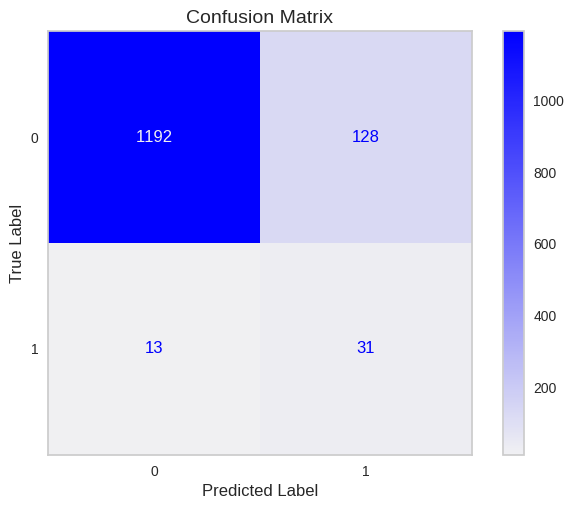

Model Parameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


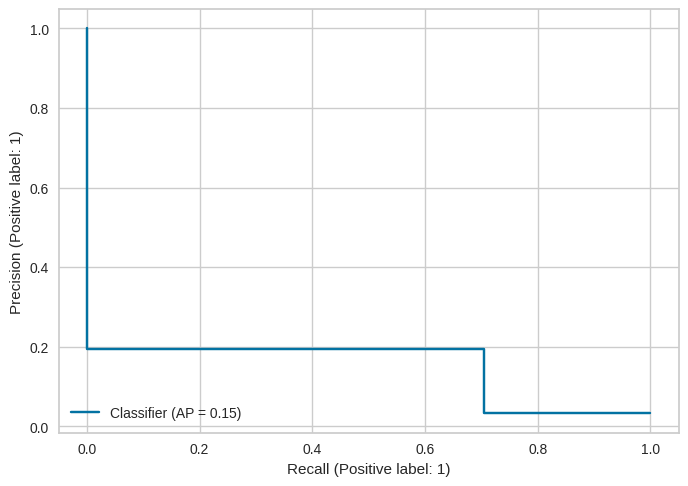

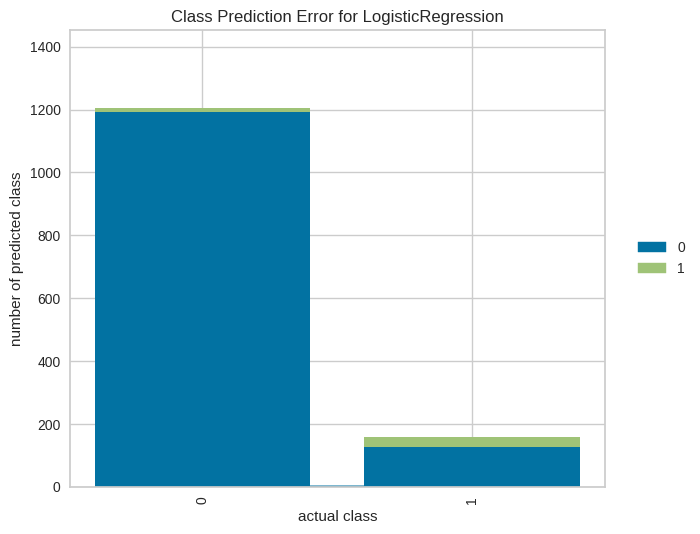

In [ ]:

# 初始化记录列表
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
models = []

def train_and_evaluate_model(model,model_name):
    model.fit(train_pca, y_train)
    y_pred = model.predict(test_pca)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print('-'*50)

    # 创建一个自定义颜色图
    cmap = sns.light_palette("blue", n_colors=100, as_cmap=True)

    # 生成混淆矩阵
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=cmap)
    ax = plt.gca()
    ax.grid(False)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    # 保存混淆矩阵为高清 PNG 图片
    file_name = f"{model_name.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').replace('__', '_')}.png"
    plt.savefig(file_name, dpi=200)
    plt.show()


    # 生成精确率-召回率曲线
    PrecisionRecallDisplay.from_predictions(y_test, y_pred)

    # 生成ROC曲线
    RocCurveDisplay.from_predictions(y_test, y_pred)

    # 计算评估指标
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=1)
    recall = recall_score(y_test, y_pred, labels=1)
    f1 = f1_score(y_test, y_pred, labels=1)
    roc_auc = roc_auc_score(y_test, y_pred, labels=1)

    # 打印模型参数
    print("Model Parameters:")
    print(model.get_params())

    # 使用 Yellowbrick 绘制 ClassPredictionError
    if re.search('catboost', str(model)) is None:
        visualizer = ClassPredictionError(model)
        visualizer.score(test_pca, y_test)
        visualizer.show()
        del visualizer

    # 记录评估指标
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)

    # 清理内存
    del acc, precision, recall, f1, roc_auc
    gc.collect()
train_and_evaluate_model(LogisticRegression(),'logistic')

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1320
           1       0.24      0.70      0.36        44

    accuracy                           0.92      1364
   macro avg       0.61      0.82      0.66      1364
weighted avg       0.97      0.92      0.94      1364

--------------------------------------------------


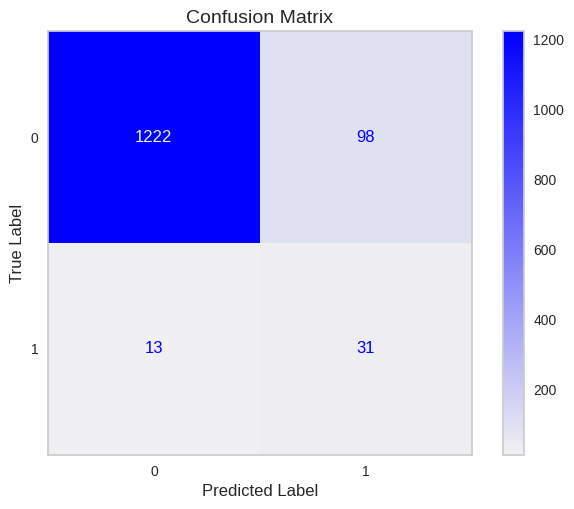

Model Parameters:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


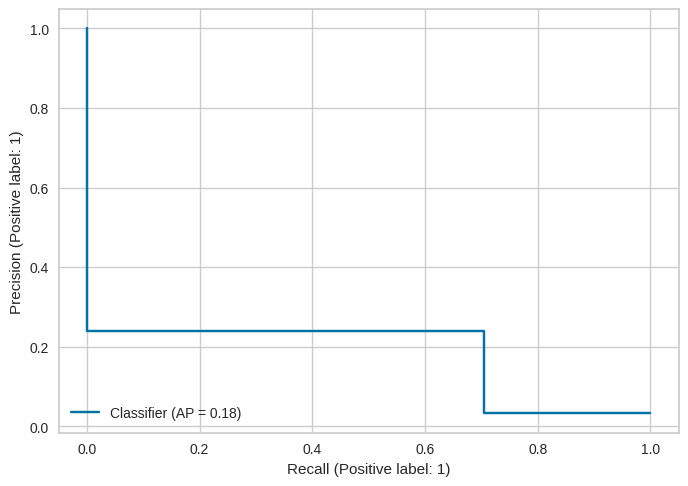

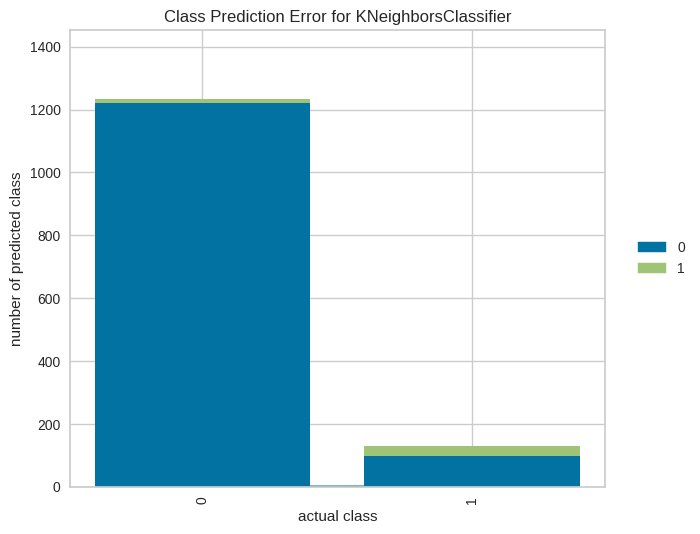

In [ ]:
train_and_evaluate_model(KNeighborsClassifier(),'kn')

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.6s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


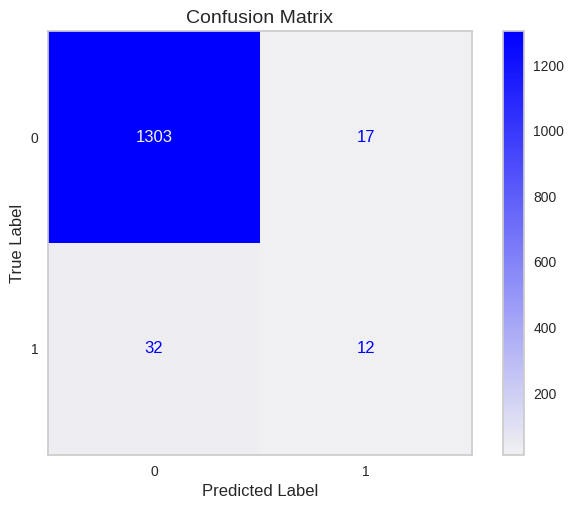

Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 2, 'warm_start': False}


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


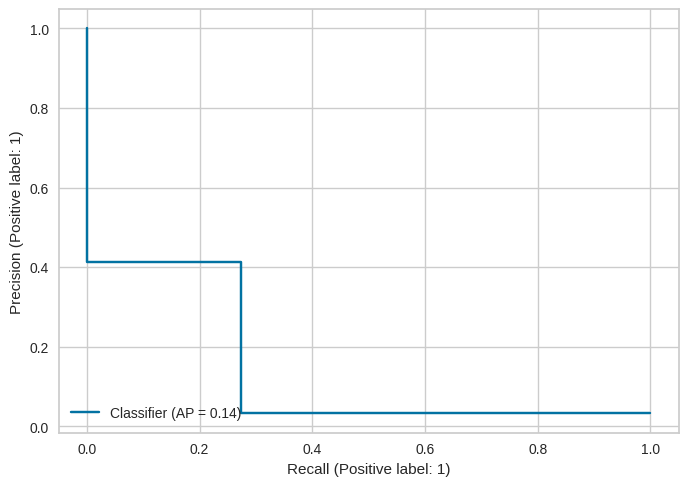

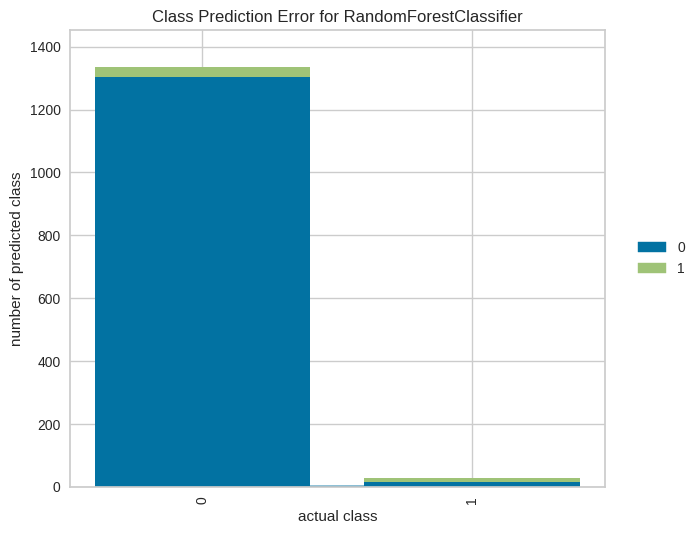

In [ ]:
train_and_evaluate_model(RandomForestClassifier(verbose=2),'randomforest')

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.38      0.52      0.44        44

    accuracy                           0.96      1364
   macro avg       0.68      0.75      0.71      1364
weighted avg       0.96      0.96      0.96      1364

--------------------------------------------------


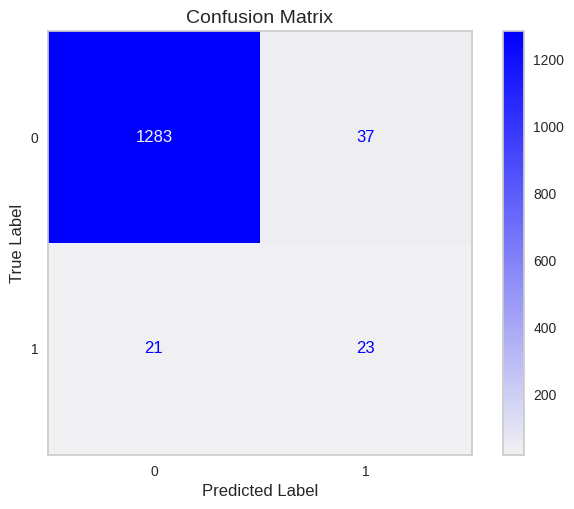

Model Parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


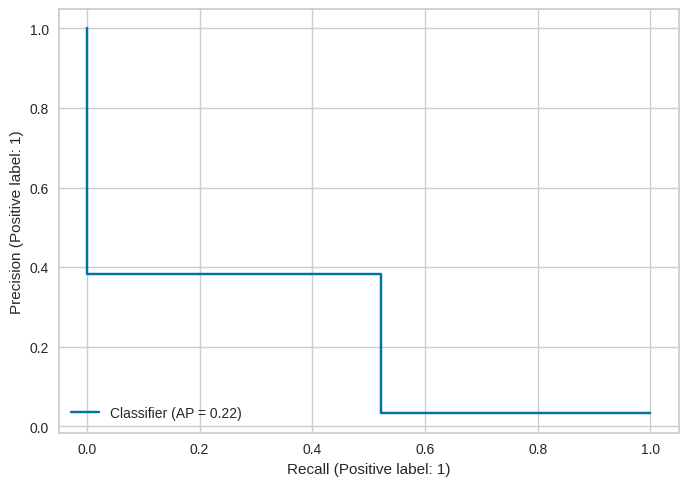

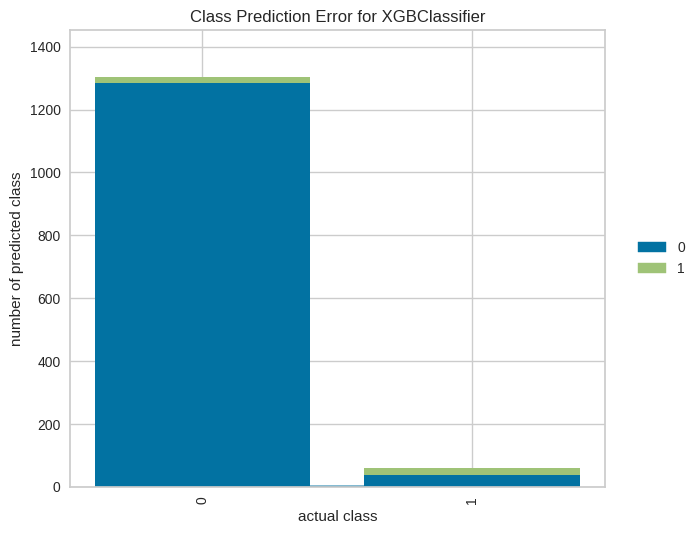

In [ ]:
train_and_evaluate_model(XGBClassifier(),'XGB')

[LightGBM] [Info] Number of positive: 5279, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 10558, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.34      0.43      0.38        44

    accuracy                           0.95      1364
   macro avg       0.66      0.70      0.68      1364
weighted avg       0.96      0.95      0.96      1364

--------------------------------------------------


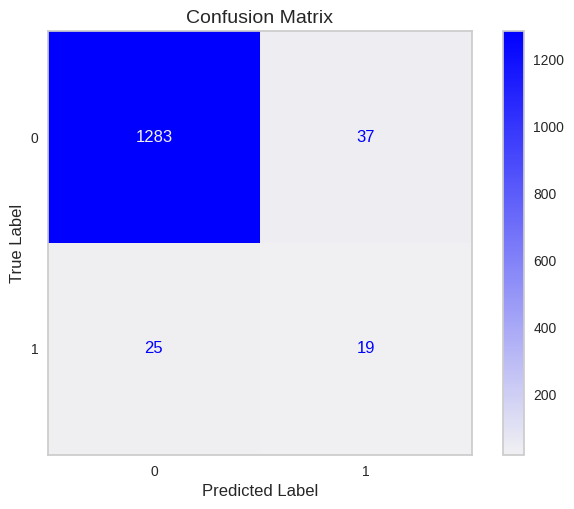

Model Parameters:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


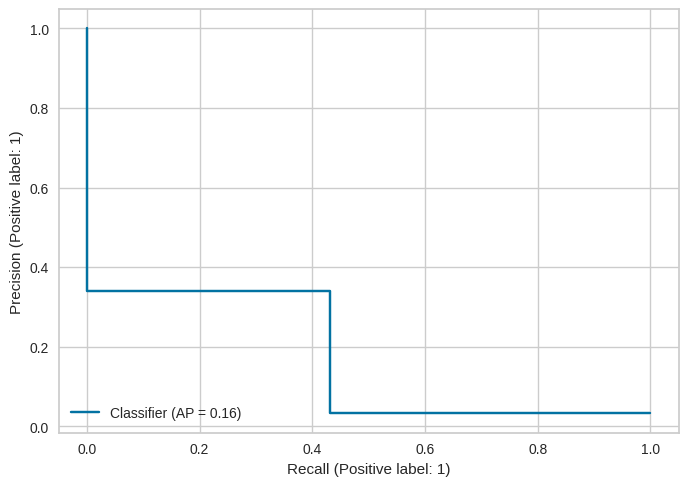

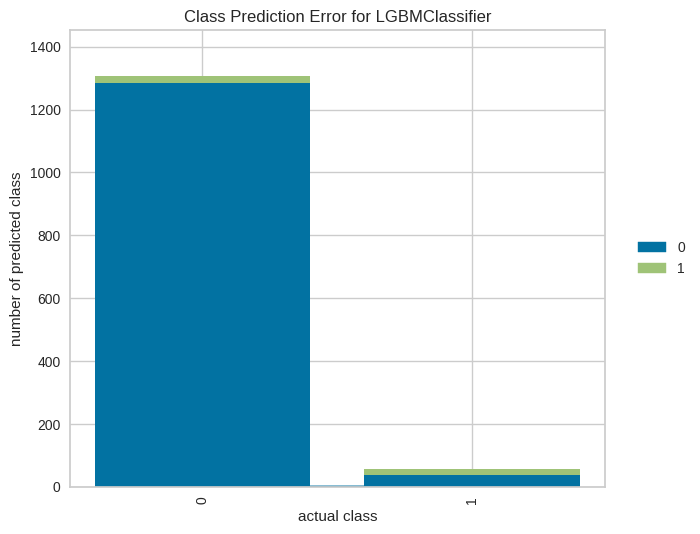

In [ ]:
train_and_evaluate_model(LGBMClassifier(),'LGB')

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.35      0.45      0.40        44

    accuracy                           0.96      1364
   macro avg       0.67      0.71      0.69      1364
weighted avg       0.96      0.96      0.96      1364

--------------------------------------------------


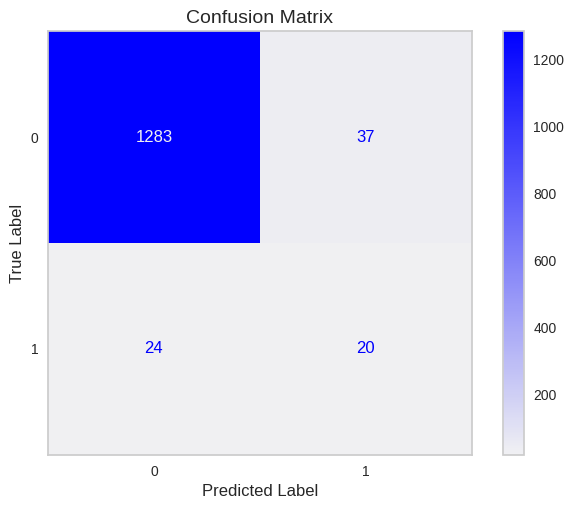

Model Parameters:
{'silent': True}


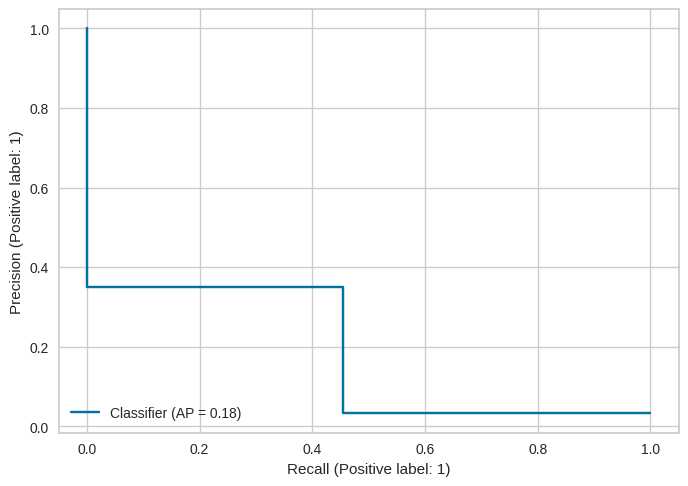

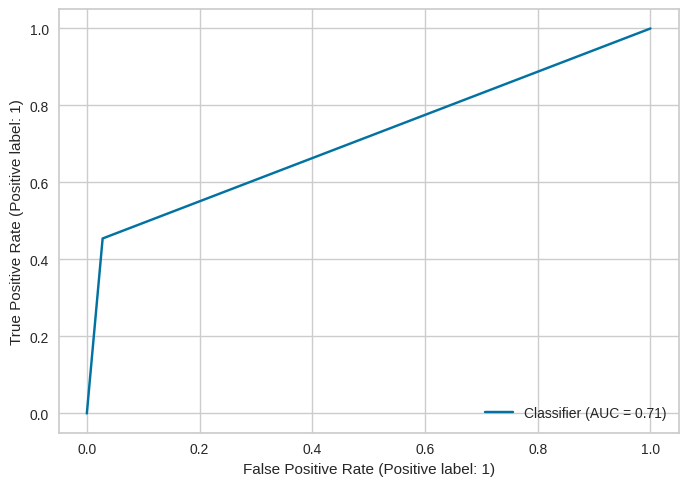

In [ ]:
train_and_evaluate_model(CatBoostClassifier(silent=True),"catboost")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.33      0.02      0.04        44

    accuracy                           0.97      1364
   macro avg       0.65      0.51      0.51      1364
weighted avg       0.95      0.97      0.95      1364

--------------------------------------------------


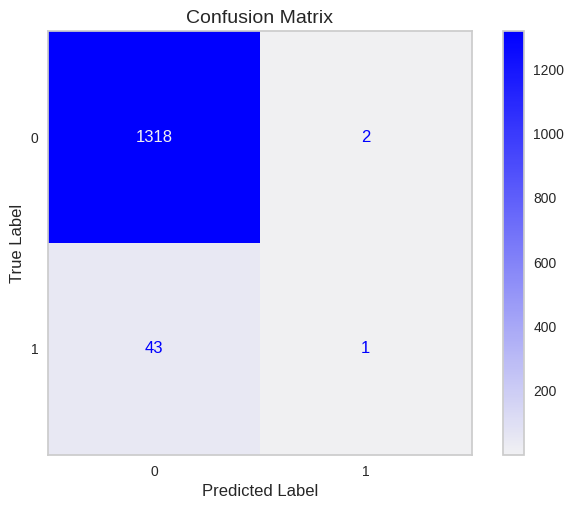

Model Parameters:
{'cv': None, 'estimators': [('ET', ExtraTreesClassifier()), ('XGB', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)), ('CAT', <catboost.core.CatBoostClassifier object at 0x7b6a4348d300>)], 'final_estimator__bootstrap': True, 'final_estimator__ccp_alpha': 0.0, 'final_estim

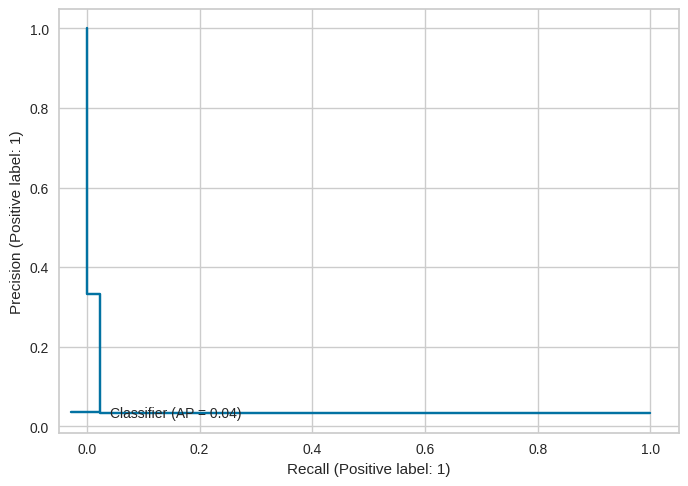

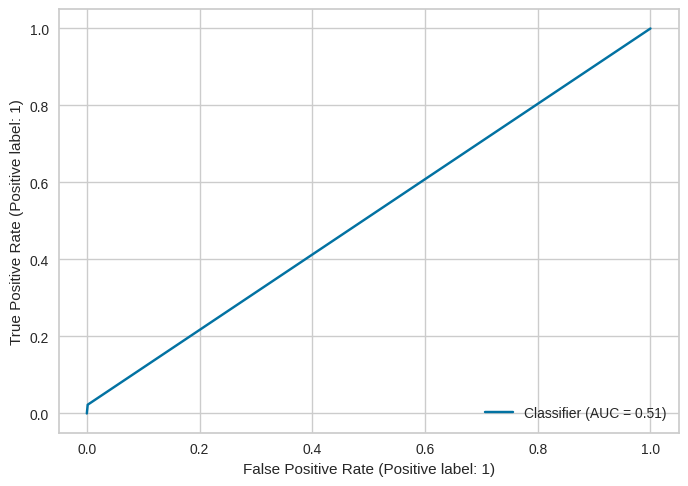

In [ ]:
train_and_evaluate_model(StackingClassifier(estimators=[
    ('ET',ExtraTreesClassifier()),
    ('XGB',XGBClassifier()),
    ('CAT',CatBoostClassifier(silent=True))
],final_estimator=RandomForestClassifier(),verbose=2),'集成学习')
stacking_model = StackingClassifier(
    estimators=[
        ('ET', ExtraTreesClassifier()),
        ('XGB', XGBClassifier()),
        ('CAT', CatBoostClassifier(silent=True))
    ],
    final_estimator=RandomForestClassifier(),
    verbose=2
)



In [ ]:
model_perfs = pd.DataFrame({'Model': models,
                            'Accuracy': accuracy_scores,
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,"StackingClassifier(estimators=[('ET', ExtraTre...",0.967009,0.333333,0.022727,0.042553,0.510606
1,"(DecisionTreeClassifier(max_features='auto', r...",0.964076,0.413793,0.272727,0.328767,0.629924
2,"XGBClassifier(base_score=None, booster=None, c...",0.957478,0.383333,0.522727,0.442308,0.747348
3,<catboost.core.CatBoostClassifier object at 0x...,0.955279,0.350877,0.454545,0.396040,0.713258
4,LGBMClassifier(),0.954545,0.339286,0.431818,0.380000,0.701894
5,KNeighborsClassifier(),0.918622,0.240310,0.704545,0.358382,0.815152
6,LogisticRegression(),0.896628,0.194969,0.704545,0.305419,0.803788


In [ ]:
# model_perfs.to_csv('model_performances.csv', index=False)

# # 提供下载文件的功能
# from google.colab import files
# files.download('model_performances.csv')